# Project - Recommender System
In this notebook we will try to built a Content Based Recommender based on:
* Genre
* "Important" Keywords
* Movie crew and cast

### Install package

In [1]:
pip install rake_nltk --upgrade

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [2]:
import pandas as pd
from pprint import PrettyPrinter
import nltk
import ast                     # To convert the string of list to list
import collections             # Implements specialized container datatypes:
                               #  OrderedDict - dict subclass that remembers the order entries were added
import operator                # Implements standard operators as functions:
                               #  itemgetter - fetches item from its operand
from rake_nltk import Rake     # Rapid Automatic Keyword Extraction algorithm
                               #  Uses stopwords for english from NLTK, and all puntuation characters by default

In [3]:
pp = PrettyPrinter(indent=4)

# Load and examine data files

In [4]:
# Reading data files
movies = pd.read_csv('data/tmdb_5000_movies.csv')
credits = pd.read_csv('data/tmdb_5000_credits.csv')

In [5]:
#Review shape of the movies dataset
movies.shape

(4803, 20)

In [6]:
# Review first records in movies dataset
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [7]:
# check data types in movies data
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4772 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [8]:
#Review shape of the credits dataset
credits.shape

(4803, 4)

In [9]:
# Review first records in credits dataset
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [10]:
#check data types in credits data
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [11]:
credits = credits.rename(columns={"movie_id": "id"})

In [12]:
# merge two datasets into one on id column
movies_df = movies.merge(credits,on="id")
movies_df2 = movies.merge(credits,on="id")

In [13]:
movies_df.shape

(4803, 23)

In [14]:
#Verifying added columns in movies data frame
movies_df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')

In [15]:
# select relevant columns for data Preprocessing
movies_df = movies_df[['genres','id','keywords','overview','title_x','cast','crew']]
movies_df.head()

,genres,id,keywords,overview,title_x,cast,crew
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...",Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A cryptic message from Bond’s past sends him o...,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",Following the death of District Attorney Harve...,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","John Carter is a war-weary, former military ca...",John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [16]:
#check for null values
movies_df.isnull().sum()

# check for null values in each row of the dataframe
null_rows = movies_df[movies_df.isnull().any(axis=1)]

# create a new dataframe with the null rows
null_df = pd.DataFrame(null_rows)

# display the new dataframe
display(null_df)

#Replace all the null values
movies_df.loc[65, 'overview'] = "Carl Fredricksen spent his entire life dreaming of exploring the globe and experiencing life to its fullest. But at age 78, life seems to have passed him by, until a twist of fate (and a persistent 8-year old Wilderness Explorer named Russell) gives him a new lease on life."
movies_df.loc[77, 'overview'] = "Growing up can be a bumpy road, and it’s no exception for Riley, who is uprooted from her Midwest life when her father starts a new job in San Francisco. Riley’s guiding emotions— Joy, Fear, Anger, Disgust and Sadness—live in Headquarters, the control centre inside Riley’s mind, where they help advise her through everyday life and tries to keep things positive, but the emotions conflict on how best to navigate a new city, house and school."
movies_df.loc[94, 'overview'] = "Light years from Earth, 26 years after being abducted, Peter Quill finds himself the prime target of a manhunt after discovering an orb wanted by Ronan the Accuser."
movies_df.loc[95, 'overview'] = "The adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage."
movies_df.loc[96, 'overview'] = "Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: “inception”, the implantation of another person’s idea into a target’s subconscious."
movies_df.loc[262, 'overview'] = "Young hobbit Frodo Baggins, after inheriting a mysterious ring from his uncle Bilbo, must leave his home in order to keep it from falling into the hands of its evil creator. Along the way, a fellowship is formed to protect the ringbearer and make sure that the ring arrives at its final destination: Mt. Doom, the only place where it can be destroyed."
movies_df.loc[287, 'overview'] = "With the help of a German bounty hunter, a freed slave sets out to rescue his wife from a brutal Mississippi plantation owner."
movies_df.loc[298, 'overview'] = "A New York stockbroker refuses to cooperate in a large securities fraud case involving corruption on Wall Street, corporate banking world and mob infiltration. Based on Jordan Belfort’s autobiography."
movies_df.loc[329, 'overview'] = "Aragorn is revealed as the heir to the ancient kings as he, Gandalf and the other members of the broken fellowship struggle to save Gondor from Sauron’s forces. Meanwhile, Frodo and Sam take the ring closer to the heart of Mordor, the dark lord’s realm."
movies_df.loc[330, 'overview'] = "Frodo and Sam are trekking to Mordor to destroy the One Ring of Power while Gimli, Legolas and Aragorn search for the orc-captured Merry and Pippin. All along, nefarious wizard Saruman awaits the Fellowship members at the Orthanc Tower in Isengard."
movies_df.loc[494, 'overview'] = "A young lion prince is cast out of his pride by his cruel uncle, who claims he killed his father. While the uncle rules with an iron paw, the prince grows up beyond the Savannah, living by a philosophy: No worries for the rest of your days. But when his past comes to haunt him, the young prince must decide his fate: Will he remain an outcast or face his demons and become what he needs to be?"
movies_df.loc[634, 'overview'] = "Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth."
movies_df.loc[662, 'overview'] = "A ticking-time-bomb insomniac and a slippery soap salesman channel primal male aggression into a shocking new form of therapy. Their concept catches on, with underground “fight clubs” forming in every town, until an eccentric gets in the way and ignites an out-of-control spiral toward oblivion."
movies_df.loc[690, 'overview'] = "A supernatural tale set on death row in a Southern prison, where gentle giant John Coffey possesses the mysterious power to heal people’s ailments. When the cell block’s head guard, Paul Edgecomb, recognizes Coffey’s miraculous gift, he tries desperately to help stave off the condemned man’s execution."
movies_df.loc[809, 'overview'] = "A man with a low IQ has accomplished great things in his life and been present during significant historic events—in each case, far exceeding what anyone imagined he could do. But despite all he has achieved, his one true love eludes him."
movies_df.loc[1553, 'overview'] = "Two homicide detectives are on a desperate hunt for a serial killer whose crimes are based on the “seven deadly sins” in this dark and haunting film that takes viewers from the tortured remains of one victim to the next. The seasoned Det. Sommerset researches each sin in an effort to get inside the killer’s mind, while his novice partner, Mills, scoffs at his efforts to unravel the case."
movies_df.loc[1818, 'overview'] = "The true story of how businessman Oskar Schindler saved over a thousand Jewish lives from the Nazis while they worked as slaves in his factory during World War II."
movies_df.loc[1881, 'overview'] = "Framed in the 1940s for the double murder of his wife and her lover, upstanding banker Andy Dufresne begins a new life at the Shawshank prison, where he puts his accounting skills to work for an amoral warden. During his long stretch in prison, Dufresne comes to be admired by the other inmates – including an older prisoner named Red – for his integrity and unquenchable sense of hope."
movies_df.loc[1990, 'overview'] = "The epic saga continues as Luke Skywalker, in hopes of defeating the evil Galactic Empire, learns the ways of the Jedi from aging master Yoda. But Darth Vader is more determined than ever to capture Luke. Meanwhile, rebel leader Princess Leia, cocky Han Solo, Chewbacca, and droids C-3PO and R2-D2 are thrown into various stages of capture, betrayal and despair."
movies_df.loc[2091, 'overview'] = "Clarice Starling is a top student at the FBI’s training academy. Jack Crawford wants Clarice to interview Dr. Hannibal Lecter, a brilliant psychiatrist who is also a violent psychopath, serving life behind bars for various acts of murder and cannibalism. Crawford believes that Lecter may have insight into a case and that Starling, as an attractive young woman, may be just the bait to draw him out."
movies_df.loc[2285, 'overview'] = "Eighties teenager Marty McFly is accidentally sent back in time to 1955, inadvertently disrupting his parents’ first meeting and attracting his mother’s romantic interest. Marty must repair the damage to history by rekindling his parents’ romance and - with the help of his eccentric inventor friend Doc Brown - return to 1985."
movies_df.loc[2294, 'overview'] = "A young girl, Chihiro, becomes trapped in a strange new world of spirits. When her parents undergo a mysterious transformation, she must call upon the courage she never knew she had to free her family."
movies_df.loc[2522, 'overview'] = "Based on the real life story of legendary cryptanalyst Alan Turing, the film portrays the nail-biting race against time by Turing and his brilliant team of code-breakers at Britain’s top-secret Government Code and Cypher School at Bletchley Park, during the darkest days of World War II."
movies_df.loc[2656, 'overview'] = "Biopic about Jorge Maria Bergoglio before he became Pope Francis I."
movies_df.loc[2731, 'overview'] = "In the continuing saga of the Corleone crime family, a young Vito Corleone grows up in Sicily and in 1910s New York. In the 1950s, Michael Corleone attempts to expand the family business into Las Vegas, Hollywood and Cuba."
movies_df.loc[2912, 'overview'] = "Princess Leia is captured and held hostage by the evil Imperial forces in their effort to take over the galactic Empire. Venturesome Luke Skywalker and dashing captain Han Solo team together with the loveable robot duo R2-D2 and C-3PO to rescue the beautiful princess and restore peace and justice in the Empire."
movies_df.loc[3232, 'overview'] = "A burger-loving hit man, his philosophical partner, a drug-addled gangster’s moll and a washed-up boxer converge in this sprawling, comedic crime caper. Their adventures unfurl in three stories that ingeniously trip back and forth in time."
movies_df.loc[3337, 'overview'] = "Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American Corleone crime family. When organized crime family patriarch, Vito Corleone barely survives an attempt on his life, his youngest son, Michael steps in to take care of the would-be killers, launching a campaign of bloody revenge."
movies_df.loc[3865, 'overview'] = "Under the direction of a ruthless instructor, a talented young drummer begins to pursue perfection at any cost, even his humanity."
movies_df.loc[4140, 'overview'] = "The life of Frank Sinatra, as an actor and singer and the steps along the way that led him to become such an icon."
movies_df.loc[4431, 'overview'] = "This call to arms documentary details the questionable ethics of the food supply industry, pointing out the power of huge supermarket chains to dictate low wages and inhumane labor conditions for farmworkers in the United States."



#check for null values
movies_df.isnull().sum()

,genres,id,keywords,overview,title_x,cast,crew
65,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 28, ""name...",155,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",NaN,The Dark Knight,"[{""cast_id"": 35, ""character"": ""Bruce Wayne"", ""...","[{""credit_id"": ""55a0eb4a925141296b0010f8"", ""de..."
77,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 35, ""name...",150540,"[{""id"": 1566, ""name"": ""dream""}, {""id"": 6513, ""...",NaN,Inside Out,"[{""cast_id"": 4, ""character"": ""Joy (voice)"", ""c...","[{""credit_id"": ""56098866c3a368681000003a"", ""de..."
94,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",118340,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",NaN,Guardians of the Galaxy,"[{""cast_id"": 1, ""character"": ""Peter Quill / St...","[{""credit_id"": ""538ce329c3a3687155003358"", ""de..."
95,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",157336,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",NaN,Interstellar,"[{""cast_id"": 9, ""character"": ""Joseph Cooper"", ...","[{""credit_id"": ""52fe4bbf9251416c910e4801"", ""de..."
96,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...",27205,"[{""id"": 1014, ""name"": ""loss of lover""}, {""id"":...",NaN,Inception,"[{""cast_id"": 1, ""character"": ""Dom Cobb"", ""cred...","[{""credit_id"": ""56e8462cc3a368408400354c"", ""de..."
262,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",120,"[{""id"": 603, ""name"": ""elves""}, {""id"": 604, ""na...",NaN,The Lord of the Rings: The Fellowship of the Ring,"[{""cast_id"": 28, ""character"": ""Frodo Baggins"",...","[{""credit_id"": ""52fe421ac3a36847f80043fb"", ""de..."
287,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 37, ""name...",68718,"[{""id"": 801, ""name"": ""bounty hunter""}, {""id"": ...",NaN,Django Unchained,"[{""cast_id"": 6, ""character"": ""Django"", ""credit...","[{""credit_id"": ""5703f6a2c3a36869850001d9"", ""de..."
298,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 18, ""name...",106646,"[{""id"": 417, ""name"": ""corruption""}, {""id"": 572...",NaN,The Wolf of Wall Street,"[{""cast_id"": 8, ""character"": ""Jordan Belfort"",...","[{""credit_id"": ""52fe4a6dc3a36847f81cd53f"", ""de..."
329,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",122,"[{""id"": 603, ""name"": ""elves""}, {""id"": 606, ""na...",NaN,The Lord of the Rings: The Return of the King,"[{""cast_id"": 12, ""character"": ""Frodo Baggins"",...","[{""credit_id"": ""52fe421bc3a36847f80046c3"", ""de..."
330,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",121,"[{""id"": 603, ""name"": ""elves""}, {""id"": 606, ""na...",NaN,The Lord of the Rings: The Two Towers,"[{""cast_id"": 13, ""character"": ""Frodo Baggins"",...","[{""credit_id"": ""52fe421ac3a36847f800454f"", ""de..."


genres      0
id          0
keywords    0
overview    0
title_x     0
cast        0
crew        0
dtype: int64

# Preprocessing Part 1: Extract values from a dict for a given key 

In [17]:
#preprocessing genres for right format
movies_df['genres'][0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [18]:
pp.pprint(movies_df['genres'][0])

('[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, '
 '"name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]')


In [19]:
# Convert string of list to list
ast.literal_eval(movies_df['genres'][0])

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [20]:
# Create function to extract values from a dict
def get_names(lst):
    feat = []
    for i in ast.literal_eval(lst):
        feat.append(i['name'])          # Get the value associated with the key 'name'
    return feat

In [21]:
# Extract genres names
movies_df['genres_names'] = movies_df['genres'].apply(get_names)

In [22]:
movies_df['genres_names'][0]

['Action', 'Adventure', 'Fantasy', 'Science Fiction']

In [23]:
movies_df[['genres','genres_names']].head()

,genres,genres_names
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[Action, Adventure, Fantasy, Science Fiction]"
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[Adventure, Fantasy, Action]"
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[Action, Adventure, Crime]"
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[Action, Crime, Drama, Thriller]"
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[Action, Adventure, Science Fiction]"


In [24]:
# Extract keywords from keywords column using the same function
movies_df['keywords_list'] = movies_df['keywords'].apply(get_names)

In [25]:
movies_df[['keywords','keywords_list']].head()

,keywords,keywords_list
0,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[culture clash, future, space war, space colon..."
1,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[ocean, drug abuse, exotic island, east india ..."
2,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[spy, based on novel, secret agent, sequel, mi..."
3,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[dc comics, crime fighter, terrorist, secret i..."
4,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[based on novel, mars, medallion, space travel..."


# Preprocessing Part 2: Extract the "important" keywords from a text string

In [26]:
# Punkt Sentence Tokenizer - pre-trained for English

# This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model
#  for abbreviation words, collocations, and words that start sentences.  It must be trained on a large
#  collection of plaintext in the target language before it can be used.
# Punkt knows that the periods in Mr. Smith and Johann S. Bach do not mark sentence boundaries.
#  And sometimes sentences can start with non-capitalized words.

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/saldavi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
movies_df.isnull().sum()

# Note: overview has 31 missing values

genres           0
id               0
keywords         0
overview         0
title_x          0
cast             0
crew             0
genres_names     0
keywords_list    0
dtype: int64

#### The function 'extract_key_words' below needs the column values it operates on to not have NaN
##### Therefore, for teaching purposes ONLY, this notebook replaces NaN with an empty string.
##### Your project should replace the missing values in overview with actual values from an external source (e.g. IMDB, Netflix, Etc.)

In [28]:
movies_df['overview'] = movies_df['overview'].fillna('')

In [29]:
movies_df['overview'].isnull().sum()

0

In [30]:
movies_df['overview'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [31]:
# Instantiate Rake
r = Rake()

In [32]:
# Extract keywords from text
r.extract_keywords_from_text(movies_df['overview'][0])

In [33]:
# Get word frequency distribution
r.get_word_frequency_distribution()

Counter({'22nd': 1,
         'century': 1,
         'paraplegic': 1,
         'marine': 1,
         'dispatched': 1,
         'moon': 1,
         'pandora': 1,
         'unique': 1,
         'mission': 1,
         'becomes': 1,
         'torn': 1,
         'following': 1,
         'orders': 1,
         'protecting': 1,
         'alien': 1,
         'civilization': 1})

In [34]:
# Get keyword phrases ranked highest to lowest
r.get_ranked_phrases()

['unique mission',
 'paraplegic marine',
 'moon pandora',
 'following orders',
 'becomes torn',
 'alien civilization',
 '22nd century',
 'protecting',
 'dispatched']

In [35]:
# Get keyword phrases ranked highest to lowest with scores
r.get_ranked_phrases_with_scores()

[(4.0, 'unique mission'),
 (4.0, 'paraplegic marine'),
 (4.0, 'moon pandora'),
 (4.0, 'following orders'),
 (4.0, 'becomes torn'),
 (4.0, 'alien civilization'),
 (4.0, '22nd century'),
 (1.0, 'protecting'),
 (1.0, 'dispatched')]

In [36]:
# Create function to extract the N most important keywords
#  N is set by parameter top_n_keywords (default = 5)
def extract_key_words(input_str, top_n_keywords=5):
    r = Rake()
    r.extract_keywords_from_text(input_str.lower())
    key_words_dict_scores = r.get_word_degrees()
    sorted_key_words_dict_scores = sorted(key_words_dict_scores.items(), key=operator.itemgetter(1), reverse=True)
    sorted_dict = collections.OrderedDict(sorted_key_words_dict_scores)
    
    # Change top_n_keywords as appropriate
    return sorted_dict, list(sorted_dict.keys())[:top_n_keywords]

In [37]:
extract_key_words(movies_df['overview'][0])

(OrderedDict([('22nd', 2),
              ('century', 2),
              ('paraplegic', 2),
              ('marine', 2),
              ('moon', 2),
              ('pandora', 2),
              ('unique', 2),
              ('mission', 2),
              ('becomes', 2),
              ('torn', 2),
              ('following', 2),
              ('orders', 2),
              ('alien', 2),
              ('civilization', 2),
              ('dispatched', 1),
              ('protecting', 1)]),
 ['22nd', 'century', 'paraplegic', 'marine', 'moon'])

In [38]:
movies_df['overview_keywords'] = movies_df['overview'].apply(lambda x: extract_key_words(x)[1]).apply(' '.join)

In [39]:

movies_df[['overview','overview_keywords']].head()

,overview,overview_keywords
0,"In the 22nd century, a paraplegic Marine is di...",22nd century paraplegic marine moon
1,"Captain Barbossa, long believed to be dead, ha...",captain barbossa long believed come
2,A cryptic message from Bond’s past sends him o...,bond terrible truth behind spectre
3,Following the death of District Attorney Harve...,attorney gotham dent batman city
4,"John Carter is a war-weary, former military ca...",carter former military captain reluctantly


# Preprocessing Part 3: Extract the director name from crew and cast names

In [40]:
#review a crew column
movies_df['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [41]:
ast.literal_eval(movies_df['crew'][0])

[{'credit_id': '52fe48009251416c750aca23',
  'department': 'Editing',
  'gender': 0,
  'id': 1721,
  'job': 'Editor',
  'name': 'Stephen E. Rivkin'},
 {'credit_id': '539c47ecc3a36810e3001f87',
  'department': 'Art',
  'gender': 2,
  'id': 496,
  'job': 'Production Design',
  'name': 'Rick Carter'},
 {'credit_id': '54491c89c3a3680fb4001cf7',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Designer',
  'name': 'Christopher Boyes'},
 {'credit_id': '54491cb70e0a267480001bd0',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Supervising Sound Editor',
  'name': 'Christopher Boyes'},
 {'credit_id': '539c4a4cc3a36810c9002101',
  'department': 'Production',
  'gender': 1,
  'id': 1262,
  'job': 'Casting',
  'name': 'Mali Finn'},
 {'credit_id': '5544ee3b925141499f0008fc',
  'department': 'Sound',
  'gender': 2,
  'id': 1729,
  'job': 'Original Music Composer',
  'name': 'James Horner'},
 {'credit_id': '52fe48009251416c750ac9c3',
  'department': 'Directing',
  

In [42]:
# Create function to extract Director name from a crew column
def get_directorname(lst):
    feat = []
    for i in ast.literal_eval(lst):
        if i['job'] == 'Director':
         feat.append(i['name'])          # Get the value associated with the key 'name'
    return feat

In [43]:
# Extract director names
movies_df['director'] = movies_df['crew'].apply(get_directorname)

In [44]:
movies_df['director'][0]

['James Cameron']

In [45]:
movies_df[['crew','director']].head()

,crew,director
0,"[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",[James Cameron]
1,"[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",[Gore Verbinski]
2,"[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",[Sam Mendes]
3,"[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",[Christopher Nolan]
4,"[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",[Andrew Stanton]


In [46]:
#review the cast column
movies_df['cast'][0]

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [47]:
# Create function to extract top three cast name from a cast column  
def get_castnames(obj):
    counter = 0
    L = []
    for i in ast.literal_eval(obj):
        if counter !=3:
            L.append(i['name'])
            counter += 1
        else:
            break
    return L

In [48]:
# Extract first top 3 actor names
movies_df['actor_names'] = movies_df['cast'].apply(get_castnames)

In [49]:
movies_df['actor_names'][0]

['Sam Worthington', 'Zoe Saldana', 'Sigourney Weaver']

In [50]:
pd.set_option('max_colwidth', None)

In [51]:
movies_df[['cast','actor_names']].head()

cast  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [52]:
#Review all columns in our data frame
movies_df.columns

Index(['genres', 'id', 'keywords', 'overview', 'title_x', 'cast', 'crew',
       'genres_names', 'keywords_list', 'overview_keywords', 'director',
       'actor_names'],
      dtype='object')

In [53]:
# Drop unnecessary columns
movies_df = movies_df.drop(['genres', 'keywords', 'overview', 'cast','crew'], axis=1)

In [54]:
#Rename title column
movies_df=movies_df.rename(columns={'title_x':'movie'})

In [55]:
#Review the data
movies_df.head(2)

,id,movie,genres_names,keywords_list,overview_keywords,director,actor_names
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, space, alien, tribe, alien planet, cgi, marine, soldier, battle, love affair, anti war, power relations, mind and soul, 3d]",22nd century paraplegic marine moon,[James Cameron],"[Sam Worthington, Zoe Saldana, Sigourney Weaver]"
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india trading company, love of one's life, traitor, shipwreck, strong woman, ship, alliance, calypso, afterlife, fighter, pirate, swashbuckler, aftercreditsstinger]",captain barbossa long believed come,[Gore Verbinski],"[Johnny Depp, Orlando Bloom, Keira Knightley]"


In [56]:
#Convert to list overview column, since it is string and all others are list
#movies_df['overview_keywords'] = movies_df['overview_keywords'].apply(lambda x:x if isinstance(x, list) else [ x ])

In [57]:
#Review the data
#movies_df.head()

# Data mining

In [58]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import string
import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Lowercase data

In [59]:
#Convert the names into lowercase and strip all the spaces between them.
#movies_df['keywords_list'] = movies_df['keywords_list'].apply(lambda x:[i.replace(" ","") for i in x])
movies_df['director'] = movies_df['director'].apply(lambda x:[str.lower(i.replace(" ", "")) for i in x])
movies_df['actor_names'] = movies_df['actor_names'].apply(lambda x:[str.lower(i.replace(" ", "")) for i in x])
movies_df['genres_names'] = movies_df['genres_names'].apply(lambda x:[str.lower(i.replace(" ", "")) for i in x])
movies_df['keywords_list'] = movies_df['keywords_list'].apply(lambda x:[str.lower(i.replace(" ", "")) for i in x])
movies_df.head(1)

,id,movie,genres_names,keywords_list,overview_keywords,director,actor_names
0,19995,Avatar,"[action, adventure, fantasy, sciencefiction]","[cultureclash, future, spacewar, spacecolony, society, spacetravel, futuristic, romance, space, alien, tribe, alienplanet, cgi, marine, soldier, battle, loveaffair, antiwar, powerrelations, mindandsoul, 3d]",22nd century paraplegic marine moon,[jamescameron],"[samworthington, zoesaldana, sigourneyweaver]"


#### Extract tokens

In [60]:
# Create function to tokenize keywords list and overview data
def tokenize(text):
    # W+ means that either a word character (A-Za-z0-9_) or a dash (-) can go there.
    tokens = re.split('\W+', text)
    return tokens

# Tokenize and lowercase data 
movies_df['overview_token'] = movies_df['overview_keywords'].apply(lambda x: tokenize(x.lower()))
movies_df.head(1)

,id,movie,genres_names,keywords_list,overview_keywords,director,actor_names,overview_token
0,19995,Avatar,"[action, adventure, fantasy, sciencefiction]","[cultureclash, future, spacewar, spacecolony, society, spacetravel, futuristic, romance, space, alien, tribe, alienplanet, cgi, marine, soldier, battle, loveaffair, antiwar, powerrelations, mindandsoul, 3d]",22nd century paraplegic marine moon,[jamescameron],"[samworthington, zoesaldana, sigourneyweaver]","[22nd, century, paraplegic, marine, moon]"


#### Remove stopwords

In [61]:
# Define stop words list
stopwords = nltk.corpus.stopwords.words('english')     # All English Stopwords

In [62]:
# Create function to remove stopwords
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopwords]
    return text

# Remove stop words from data
movies_df['keywords_nostop'] = movies_df['keywords_list'].apply(lambda x: remove_stopwords(x))
movies_df['overview_nostop'] = movies_df['overview_token'].apply(lambda x: remove_stopwords(x))
movies_df.head(1)

,id,movie,genres_names,keywords_list,overview_keywords,director,actor_names,overview_token,keywords_nostop,overview_nostop
0,19995,Avatar,"[action, adventure, fantasy, sciencefiction]","[cultureclash, future, spacewar, spacecolony, society, spacetravel, futuristic, romance, space, alien, tribe, alienplanet, cgi, marine, soldier, battle, loveaffair, antiwar, powerrelations, mindandsoul, 3d]",22nd century paraplegic marine moon,[jamescameron],"[samworthington, zoesaldana, sigourneyweaver]","[22nd, century, paraplegic, marine, moon]","[cultureclash, future, spacewar, spacecolony, society, spacetravel, futuristic, romance, space, alien, tribe, alienplanet, cgi, marine, soldier, battle, loveaffair, antiwar, powerrelations, mindandsoul, 3d]","[22nd, century, paraplegic, marine, moon]"


In [63]:
# Drop unnecessary columns
movies_df = movies_df.drop([ 'keywords_list','overview_keywords', 'overview_token'], axis=1)
movies_df.head(1)

,id,movie,genres_names,director,actor_names,keywords_nostop,overview_nostop
0,19995,Avatar,"[action, adventure, fantasy, sciencefiction]",[jamescameron],"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar, spacecolony, society, spacetravel, futuristic, romance, space, alien, tribe, alienplanet, cgi, marine, soldier, battle, loveaffair, antiwar, powerrelations, mindandsoul, 3d]","[22nd, century, paraplegic, marine, moon]"


In [64]:
#select the features that are required
movies_df['features'] = movies_df['genres_names'] + movies_df['keywords_nostop'] + movies_df['overview_nostop'] 
+ movies_df['actor_names'] + movies_df['director']
                                                                                                                      
movies_df.head(1)                                                                                                                  

,id,movie,genres_names,director,actor_names,keywords_nostop,overview_nostop,features
0,19995,Avatar,"[action, adventure, fantasy, sciencefiction]",[jamescameron],"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar, spacecolony, society, spacetravel, futuristic, romance, space, alien, tribe, alienplanet, cgi, marine, soldier, battle, loveaffair, antiwar, powerrelations, mindandsoul, 3d]","[22nd, century, paraplegic, marine, moon]","[action, adventure, fantasy, sciencefiction, cultureclash, future, spacewar, spacecolony, society, spacetravel, futuristic, romance, space, alien, tribe, alienplanet, cgi, marine, soldier, battle, loveaffair, antiwar, powerrelations, mindandsoul, 3d, 22nd, century, paraplegic, marine, moon]"


### Apply stemming

In [65]:
ps = nltk.PorterStemmer()

# Create function to apply stemmer
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

# Apply Porter Stemmer
movies_df['features'] = movies_df['features'].apply(lambda x: stemming(x))
movies_df.head(1)

,id,movie,genres_names,director,actor_names,keywords_nostop,overview_nostop,features
0,19995,Avatar,"[action, adventure, fantasy, sciencefiction]",[jamescameron],"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar, spacecolony, society, spacetravel, futuristic, romance, space, alien, tribe, alienplanet, cgi, marine, soldier, battle, loveaffair, antiwar, powerrelations, mindandsoul, 3d]","[22nd, century, paraplegic, marine, moon]","[action, adventur, fantasi, sciencefict, cultureclash, futur, spacewar, spacecoloni, societi, spacetravel, futurist, romanc, space, alien, tribe, alienplanet, cgi, marin, soldier, battl, loveaffair, antiwar, powerrel, mindandsoul, 3d, 22nd, centuri, parapleg, marin, moon]"


In [66]:
# Drop unnecessary columns
movies_df = movies_df.drop([ 'id','genres_names', 'director', 'actor_names', 'keywords_nostop','overview_nostop'], axis=1)
movies_df.head(1)

,movie,features
0,Avatar,"[action, adventur, fantasi, sciencefict, cultureclash, futur, spacewar, spacecoloni, societi, spacetravel, futurist, romanc, space, alien, tribe, alienplanet, cgi, marin, soldier, battl, loveaffair, antiwar, powerrel, mindandsoul, 3d, 22nd, centuri, parapleg, marin, moon]"


In [67]:
movies_df['features'] = movies_df['features'].apply(lambda x:" ".join(x))
movies_df.head()

,movie,features
0,Avatar,action adventur fantasi sciencefict cultureclash futur spacewar spacecoloni societi spacetravel futurist romanc space alien tribe alienplanet cgi marin soldier battl loveaffair antiwar powerrel mindandsoul 3d 22nd centuri parapleg marin moon
1,Pirates of the Caribbean: At World's End,adventur fantasi action ocean drugabus exoticisland eastindiatradingcompani loveofone'slif traitor shipwreck strongwoman ship allianc calypso afterlif fighter pirat swashbuckl aftercreditssting captain barbossa long believ come
2,Spectre,action adventur crime spi basedonnovel secretag sequel mi6 britishsecretservic unitedkingdom bond terribl truth behind spectr
3,The Dark Knight Rises,action crime drama thriller dccomic crimefight terrorist secretident burglar hostagedrama timebomb gothamc vigilant cover-up superhero villai tragichero terror destruct catwoman catburglar imax flood criminalunderworld batman attorney gotham dent batman citi
4,John Carter,action adventur sciencefict basedonnovel mar medallion spacetravel princess alien steampunk martian escap edgarriceburrough alienrac superhumanstrength marscivil swordandplanet 19thcenturi 3d carter former militari captain reluctantli


In [68]:
movies_df.set_index('movie', inplace = True)
movies_df.head()

,features
movie,
Avatar,action adventur fantasi sciencefict cultureclash futur spacewar spacecoloni societi spacetravel futurist romanc space alien tribe alienplanet cgi marin soldier battl loveaffair antiwar powerrel mindandsoul 3d 22nd centuri parapleg marin moon
Pirates of the Caribbean: At World's End,adventur fantasi action ocean drugabus exoticisland eastindiatradingcompani loveofone'slif traitor shipwreck strongwoman ship allianc calypso afterlif fighter pirat swashbuckl aftercreditssting captain barbossa long believ come
Spectre,action adventur crime spi basedonnovel secretag sequel mi6 britishsecretservic unitedkingdom bond terribl truth behind spectr
The Dark Knight Rises,action crime drama thriller dccomic crimefight terrorist secretident burglar hostagedrama timebomb gothamc vigilant cover-up superhero villai tragichero terror destruct catwoman catburglar imax flood criminalunderworld batman attorney gotham dent batman citi
John Carter,action adventur sciencefict basedonnovel mar medallion spacetravel princess alien steampunk martian escap edgarriceburrough alienrac superhumanstrength marscivil swordandplanet 19thcenturi 3d carter former militari captain reluctantli


## Experiment 1

# Vectorize data - TF-IDF

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [70]:
# Instantiate TF-IDF vectorizer
tfidf = TfidfVectorizer(analyzer='word', stop_words='english')

In [71]:
# Apply TfidfVectorizer (convert the text into numbers)
tfidf_matrix = tfidf.fit_transform(movies_df['features'])
tfidf_matrix

<4803x13816 sparse matrix of type '<class 'numpy.float64'>'
	with 68723 stored elements in Compressed Sparse Row format>

In [72]:
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_matrix.head(5)

,00,000,007,10,100,10th,11,12,1200,12th,...,zooey,zookeep,zorin,zuckerberg,zurich,zuzu,γη,卧底肥妈,绝地奶霸,超级妈妈
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Generate similarities matrix to make recommendations

In [73]:
#Importing Sckit learn libraries for calculating Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

In [74]:
# Calculate the cosine similarity of each item with every other item in the dataset
cosine_similarities = cosine_similarity(tfidf_matrix)
cosine_similarities.shape

(4803, 4803)

In [75]:
type(cosine_similarities)

numpy.ndarray

In [76]:
movie_indices = pd.Series(movies_df.index)

In [77]:
movie_indices

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: movie, Length: 4803, dtype: object

## Create content-based movie recommender

#### Making a recommendation function

In [78]:
def recommendations(movie, cosine_similarities=cosine_similarities):
    
    recommended_movies = []
    
    # Get index of the movie that matches the name
    movie_index = movie_indices[movie_indices == movie].index[0]

    # Create a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_similarities[movie_index]).sort_values(ascending = False)

    # Get the indexes of the 5 most similar movies except itself
    top_indexes = list(score_series.iloc[1:6].index)
    
    # Populate the list with the names of the top 5 matching movies
    for i in top_indexes:
        recommended_movies.append(list(movies_df.index)[i])
        
    return recommended_movies

## Movie recommendations

In [79]:
# Pick a movie and make a recommendation
recommendations('The Dark Knight')

['The Dark Knight Rises',
 'Batman Returns',
 'Batman Begins',
 'Batman: The Dark Knight Returns, Part 2',
 'Batman']

In [80]:
# Pick a movie and make a recommendation
recommendations('The Shawshank Redemption')

["Madea's Witness Protection",
 'For Your Consideration',
 "We're No Angels",
 'Welcome to the Rileys',
 'The Night Visitor']

In [81]:
# Pick a movie and make a recommendation
recommendations('Frozen')

['Aladdin',
 'Snow White and the Seven Dwarfs',
 'The Snow Queen',
 'Valiant',
 'Return to Never Land']

## Experiment 2

## Creativity Euclidean Distance

In [82]:
from sklearn.metrics.pairwise import euclidean_distances

# Calculate the euclidean distance of each item with every other item in the dataset
euclidean_distances = euclidean_distances(tfidf_matrix)

euclidean_distances.shape


(4803, 4803)

In [83]:
def recommendations2(movie, euclidean_distances = euclidean_distances):
    
    recommended_movies = []
    
    # Get index of the movie that matches the name
    movie_index = movie_indices[movie_indices == movie].index[0]

    # Create a Series with the similarity scores in descending order
    score_series = pd.Series(euclidean_distances[movie_index]).sort_values(ascending = True)

    # Get the indexes of the 5 most similar movies except itself
    top_indexes = list(score_series.iloc[1:6].index)
    
    # Populate the list with the names of the top 5 matching movies
    for i in top_indexes:
        recommended_movies.append(list(movies_df.index)[i])
        
    return recommended_movies


In [84]:
recommendations2("The Dark Knight")

['The Dark Knight Rises',
 'Batman Returns',
 'Batman Begins',
 'Batman: The Dark Knight Returns, Part 2',
 'Batman']

## Now Using CountVectorizer w/Euclidean Distance

In [85]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(analyzer='word', stop_words='english')
count_matrix = count.fit_transform(movies_df['features'])

euclidean_distances = euclidean_distances(count_matrix)

def recommendations2(movie, euclidean_distances=euclidean_distances):
    recommended_movies = []
    movie_index = movie_indices[movie_indices == movie].index[0]
    score_series = pd.Series(euclidean_distances[movie_index]).sort_values(ascending=True)
    top_indexes = list(score_series.iloc[1:6].index)
    for i in top_indexes:
        recommended_movies.append(list(movies_df.index)[i])
    return recommended_movies


In [86]:
recommendations("Frozen")

['Aladdin',
 'Snow White and the Seven Dwarfs',
 'The Snow Queen',
 'Valiant',
 'Return to Never Land']

In [87]:
recommendations2("Frozen")

['Return to Never Land',
 'Valiant',
 "Teacher's Pet",
 "Madagascar 3: Europe's Most Wanted",
 'The Snow Queen']

In [88]:
recommendations("The Dark Knight")

['The Dark Knight Rises',
 'Batman Returns',
 'Batman Begins',
 'Batman: The Dark Knight Returns, Part 2',
 'Batman']

In [89]:
recommendations2("The Dark Knight")

['The Rise of the Krays',
 'Blood Ties',
 'Sympathy for Lady Vengeance',
 'Dutch Kills',
 "Sarah's Key"]

In [90]:
recommendations2('The Shawshank Redemption')

["Madea's Witness Protection",
 'Blood Ties',
 'Misconduct',
 'Filly Brown',
 'Dutch Kills']

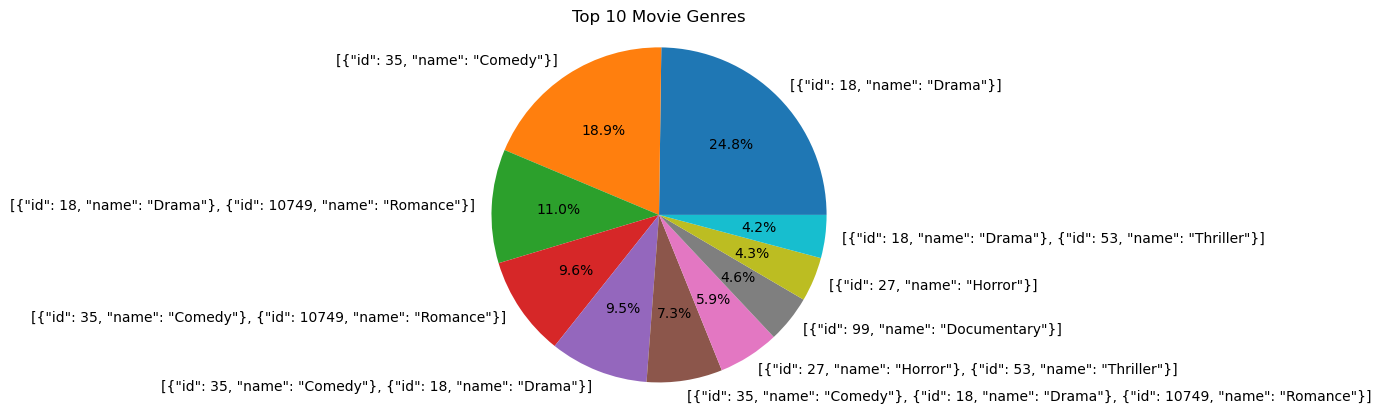

In [92]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the movies dataset
movies_df = pd.read_csv('data/tmdb_5000_movies.csv')

# Split the genres column by '|'
movies_df['genres'] = movies_df['genres'].str.split('|')

# Create a new dataframe with the genres and the number of movies in each genre
genre_counts = pd.DataFrame(movies_df['genres'].explode().value_counts())

# Select only the top 10 genres
top_genres = genre_counts.head(10)

# Plot the pie chart
plt.pie(top_genres['genres'], labels=top_genres.index, autopct='%1.1f%%')
plt.title('Top 10 Movie Genres')
plt.axis('equal')
plt.show()
